Импорт библиотек и загрузка данных

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import time

warnings.filterwarnings('ignore')

In [16]:
# Загрузка данных
data_lec = pd.read_csv('data_lec.csv')
target_lec = pd.read_csv('target_lec.csv')

Анализ данных и обработка

In [17]:
data_lec.head()

,Unnamed: 0,timestamp,ppm1,temp1,temp2,ppm2,gas_opening1,press1,rotationspeed1,press3,...,SIM2,LSF2,electric_ampere2,electric_ampere3,temp5,target,target_ffill,electric_ampere_delta1,coeffs_current1,coeffs_temp1
0,0,2023-09-04 05:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006982,NaN,NaN
1,1,2023-09-04 05:02:00+00:00,NaN,767.616089,301.616760,NaN,4.334852,0.338180,0.0,0.0,...,NaN,NaN,27.0,NaN,781.098145,NaN,NaN,0.018020,NaN,NaN
2,2,2023-09-04 05:03:00+00:00,NaN,767.758545,302.511932,NaN,4.304109,0.388817,0.0,0.0,...,NaN,NaN,27.0,NaN,781.050659,NaN,NaN,0.015809,NaN,NaN
3,3,2023-09-04 05:04:00+00:00,NaN,767.806030,303.645836,NaN,4.303205,0.353552,0.0,0.0,...,NaN,NaN,27.0,NaN,781.050659,NaN,NaN,0.013946,NaN,NaN
4,4,2023-09-04 05:05:00+00:00,NaN,767.806000,304.222733,NaN,4.290545,0.349031,0.0,0.0,...,NaN,NaN,27.0,NaN,780.870209,NaN,NaN,0.023489,NaN,NaN


In [18]:
data_lec.columns

Index(['Unnamed: 0', 'timestamp', 'ppm1', 'temp1', 'temp2', 'ppm2',
       'gas_opening1', 'press1', 'rotationspeed1', 'press3', 'temp3', 'press2',
       'press4', 'temp4', 'electric_ampere1', 'speed1', 'press5',
       'electric_consumption2', 'press6', 'speed2', 'electric_consumption3',
       'inlet_pressure1', 'press7', 'gas_consumption1', 'press8', 'press9',
       'electric_consumption4', 'electric_consumption5', 'press10', 'sito1',
       'moisture1', 'ALM1', 'CaO1', 'SIM1', 'LSF1', 'sito2', 'moisture2',
       'ALM2', 'CaO2', 'SIM2', 'LSF2', 'electric_ampere2', 'electric_ampere3',
       'temp5', 'target', 'target_ffill', 'electric_ampere_delta1',
       'coeffs_current1', 'coeffs_temp1'],
      dtype='object')

In [19]:
target_lec.head()

,timestamp,target
0,2023-09-06 07:17:00+00:00,0.99480
1,2023-09-06 08:46:00+00:00,1.98218
2,2023-09-06 11:24:00+00:00,2.29000
3,2023-09-06 13:21:00+00:00,2.13000
4,2023-09-06 14:53:00+00:00,1.15249


In [20]:
# Преобразование временных меток в формат datetime для корректной работы с временными рядами
data_lec['timestamp'] = pd.to_datetime(data_lec['timestamp'])
target_lec['timestamp'] = pd.to_datetime(target_lec['timestamp'])

# Объединение датасетов data_lec и target_lec по столбцу timestamp
merged_data = pd.merge_asof(
    data_lec.sort_values('timestamp'),
    target_lec.sort_values('timestamp'),
    on='timestamp',
    direction='backward'
)

In [21]:
merged_data.columns

Index(['Unnamed: 0', 'timestamp', 'ppm1', 'temp1', 'temp2', 'ppm2',
       'gas_opening1', 'press1', 'rotationspeed1', 'press3', 'temp3', 'press2',
       'press4', 'temp4', 'electric_ampere1', 'speed1', 'press5',
       'electric_consumption2', 'press6', 'speed2', 'electric_consumption3',
       'inlet_pressure1', 'press7', 'gas_consumption1', 'press8', 'press9',
       'electric_consumption4', 'electric_consumption5', 'press10', 'sito1',
       'moisture1', 'ALM1', 'CaO1', 'SIM1', 'LSF1', 'sito2', 'moisture2',
       'ALM2', 'CaO2', 'SIM2', 'LSF2', 'electric_ampere2', 'electric_ampere3',
       'temp5', 'target_x', 'target_ffill', 'electric_ampere_delta1',
       'coeffs_current1', 'coeffs_temp1', 'target_y'],
      dtype='object')

 1. Построить виртуальный датчик (ВД) показателя в таргете, который сможет расчитывать значение в настоящий момент времени,  что существенно снизит нагрузку на лабораторию и даст возможность оператору быстрее реагировать на изменения в процессе.

In [22]:
# Заполнение пропущенных значений
# Пропуски заполняются методом forward fill (заполнение предыдущими значениями), затем медианой
merged_data = merged_data.fillna(method='ffill').fillna(merged_data.median())

# Разделение признаков и целевого значения
features = merged_data.drop(columns=['Unnamed: 0', 'timestamp', 'target_x', 'target_y', 'target_ffill'])
target = merged_data['target_y']

# Удаление строк с пропущенными значениями целевого признака
features = features[~target.isnull()]
target = target.dropna()

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [23]:
# Модель виртуального датчика
virtual_sensor_model = RandomForestRegressor(random_state=42, n_estimators=50)
virtual_sensor_model.fit(X_train, y_train)

# Предсказание текущих значений
y_pred_current = virtual_sensor_model.predict(X_test)

# Оценка модели
rmse_VS = np.sqrt(mean_squared_error(y_test, y_pred_current))
mae_VS = mean_absolute_error(y_test, y_pred_current)
r2_VS = r2_score(y_test, y_pred_current)
print("RMSE: ", rmse_VS)
print("MAE: ", mae_VS)
print("R^2: ", r2_VS)

RMSE:  0.0395448600575142
MAE:  0.0074882157405898216
R^2:  0.9935512446076835


Симуляция работы виртуального датчика в реальном времени

In [24]:
def real_time_sensor(data_stream, model, feature_columns, lower=1, upper=2):

    for _, row in data_stream.iterrows():
        # Формирование признаков для текущей строки
        current_features = row[feature_columns].values.reshape(1, -1)
        
        # Предсказание текущего значения target
        predicted_target = model.predict(current_features)[0]
        
        # Оповещение при выходе за пороги
        timestamp = row['timestamp']
        if predicted_target < lower:
            print(f"⚠️ {timestamp}: target опустился ниже {lower}: {predicted_target:.3f}")
        elif predicted_target > upper:
            print(f"⚠️ {timestamp}: target превысил {upper}: {predicted_target:.3f}")
        else:
            print(f"✅ {timestamp}: target в пределах нормы: {predicted_target:.3f}")
        
        # Задержка (в рамках симуляции)
        time.sleep(1)

# Пример потока данных (выбираем несколько для теста)
data_stream = merged_data.sample(50).sort_values(by='timestamp')  # Имитация поступающих данных

# Запуск виртуального датчика
real_time_sensor(data_stream, virtual_sensor_model, features.columns)

⚠️ 2023-09-04 23:36:00+00:00: target опустился ниже 1: 0.751
✅ 2023-09-06 11:15:00+00:00: target в пределах нормы: 1.982
✅ 2023-09-07 03:41:00+00:00: target в пределах нормы: 1.410
⚠️ 2023-09-08 08:46:00+00:00: target превысил 2: 2.406
⚠️ 2023-09-09 13:06:00+00:00: target превысил 2: 3.431
✅ 2023-09-09 15:21:00+00:00: target в пределах нормы: 1.907
⚠️ 2023-09-12 06:36:00+00:00: target опустился ниже 1: 0.812
✅ 2023-09-12 11:30:00+00:00: target в пределах нормы: 1.484
✅ 2023-09-12 21:02:00+00:00: target в пределах нормы: 1.112
⚠️ 2023-09-15 13:21:00+00:00: target опустился ниже 1: 0.700
⚠️ 2023-09-17 03:11:00+00:00: target превысил 2: 2.827
✅ 2023-09-17 04:51:00+00:00: target в пределах нормы: 1.043
⚠️ 2023-09-17 13:41:00+00:00: target опустился ниже 1: 0.855
✅ 2023-09-19 09:32:00+00:00: target в пределах нормы: 1.780
⚠️ 2023-09-19 17:46:00+00:00: target опустился ниже 1: 0.751
⚠️ 2023-09-21 15:26:00+00:00: target опустился ниже 1: 0.751
⚠️ 2023-09-21 17:57:00+00:00: target опустился ни

2. Построить прогнозную модель, которая на горизонте в 15 минут может установить значение таргета.

In [25]:
# Прогнозная модель (горизонт 15 мин)
# Сдвиг целевого признака на 15 шагов (данные у нас с интервалом в 1 мин)
shifted_target = merged_data['target_y'].shift(-15)
forecast_features = features[:-15]
forecast_target = shifted_target[:-15]

# Разделение данных на обучающую и тестовую выборки для прогнозирования
X_train_forecast, X_test_forecast, y_train_forecast, y_test_forecast = train_test_split(
    forecast_features, forecast_target, test_size=0.2, random_state=42
)

# Обучение модели для прогноза на 15 мин вперед
forecast_model = RandomForestRegressor(random_state=42, n_estimators=50)
forecast_model.fit(X_train_forecast, y_train_forecast)

# Предсказание значений на горизонте 15 мин
y_pred_forecast = forecast_model.predict(X_test_forecast)

# Оценка модели
rmse_forecast = np.sqrt(mean_squared_error(y_test_forecast, y_pred_forecast))
mae_forecast = mean_absolute_error(y_test_forecast, y_pred_forecast)
r2_forecast = r2_score(y_test_forecast, y_pred_forecast)
print("RMSE: ", rmse_forecast)
print("MAE: ", mae_forecast)
print("R^2: ", r2_forecast)

RMSE:  0.053149257735238396
MAE:  0.008500586472196703
R^2:  0.9882159861926785


Симуляция прогнозирования в реальном времени (горизонт 15 минут)

In [26]:
def real_time_forecast(data_stream, model, feature_columns, lower=1, upper=2):

    for _, row in data_stream.iterrows():
        # Формирование признаков для текущей строки
        current_features = row[feature_columns].values.reshape(1, -1)
        
        # Прогноз target на 15 минут вперед
        predicted_target = model.predict(current_features)[0]
        
        # Оповещение при выходе за пороги
        timestamp = row['timestamp']
        if predicted_target < lower:
            print(f"⚠️ Прогноз {timestamp}: target через 15 минут опустится ниже {lower}: {predicted_target:.3f}")
        elif predicted_target > upper:
            print(f"⚠️ Прогноз {timestamp}: target через 15 минут превысит {upper}: {predicted_target:.3f}")
        else:
            print(f"✅ Прогноз {timestamp}: target через 15 минут в пределах нормы: {predicted_target:.3f}")
        
        # Задержка (в рамках симуляции)
        time.sleep(1)

# Пример потока данных (выбираем несколько для теста)
data_stream = merged_data.sample(50).sort_values(by='timestamp')  # Имитация поступающих данных

# Запуск прогнозной модели
real_time_forecast(data_stream, forecast_model, features.columns)

✅ Прогноз 2023-09-11 10:22:00+00:00: target через 15 минут в пределах нормы: 1.204
✅ Прогноз 2023-09-11 17:34:00+00:00: target через 15 минут в пределах нормы: 1.112
⚠️ Прогноз 2023-09-13 17:35:00+00:00: target через 15 минут опустится ниже 1: 0.744
⚠️ Прогноз 2023-09-14 12:49:00+00:00: target через 15 минут опустится ниже 1: 0.958
✅ Прогноз 2023-09-14 20:09:00+00:00: target через 15 минут в пределах нормы: 1.237
✅ Прогноз 2023-09-14 20:39:00+00:00: target через 15 минут в пределах нормы: 1.237
✅ Прогноз 2023-09-14 23:34:00+00:00: target через 15 минут в пределах нормы: 1.237
✅ Прогноз 2023-09-15 06:44:00+00:00: target через 15 минут в пределах нормы: 1.179
⚠️ Прогноз 2023-09-16 11:58:00+00:00: target через 15 минут опустится ниже 1: 0.874
✅ Прогноз 2023-09-16 13:52:00+00:00: target через 15 минут в пределах нормы: 1.141
⚠️ Прогноз 2023-09-16 23:46:00+00:00: target через 15 минут опустится ниже 1: 0.456
✅ Прогноз 2023-09-18 18:41:00+00:00: target через 15 минут в пределах нормы: 1.097


3*. Построить модель, которая может определить значение таргета в случае изменения показателя gas_consumption1 на шаг 150 (текущее значение + 150) в последующие 15 минут.

In [33]:
# Создание данных для обучения с изменением gas_consumption1
merged_data['gas_consumption1_modified'] = merged_data['gas_consumption1'] + 150
merged_data['target_shifted'] = merged_data['target_y'].shift(-15)

# Исключение строк с пропущенными значениями
merged_data_modified = merged_data.dropna(subset=['target_shifted'])

# Формирование признаков и целевой переменной
modified_features = merged_data_modified.copy()
modified_features['gas_consumption1'] = merged_data_modified['gas_consumption1_modified']

# Используем только признаки, которые соответствуют исходной модели
forecast_features_gas = modified_features[features.columns]
forecast_target_gas = merged_data_modified['target_shifted']

# Разделение данных на обучающую и тестовую выборки
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(
    forecast_features_gas, forecast_target_gas, test_size=0.2, random_state=42
)

# Обучение модели для прогноза
forecast_model_gas_consumption1_changed = RandomForestRegressor(random_state=42, n_estimators=50)
forecast_model_gas_consumption1_changed.fit(X_train_mod, y_train_mod)

# Предсказание с учетом изменений
y_pred_gas_consumption1_changed = forecast_model_gas_consumption1_changed.predict(X_test_mod)

In [34]:
# Оценка модели
rmse_gas_consumption1_changed = np.sqrt(mean_squared_error(y_test_gas, y_pred_gas_consumption1_changed))
mae_gas_consumption1_changed = mean_absolute_error(y_test_gas, y_pred_gas_consumption1_changed)
r2_gas_consumption1_changed = r2_score(y_test_gas, y_pred_gas_consumption1_changed)
print("RMSE: ", rmse_gas_consumption1_changed)
print("MAE: ", mae_gas_consumption1_changed)
print("R^2: ", r2_gas_consumption1_changed)

RMSE:  0.05365284671635529
MAE:  0.008577002129508182
R^2:  0.9879916213194326


Симуляция для прогноза с изменением gas_consumption1

In [35]:
def real_time_forecast_gas_consumption1_changed(data_stream, model, feature_columns, lower=1, upper=2):

    for _, row in data_stream.iterrows():
        # Изменение gas_consumption1
        row['gas_consumption1'] += 150

        # Формирование признаков для текущей строки
        current_features = row[feature_columns].values.reshape(1, -1)
        
        # Прогноз target на 15 минут вперед
        predicted_target = model.predict(current_features)[0]
        
        # Оповещение при выходе за пороги
        timestamp = row['timestamp']
        if predicted_target < lower:
            print(f"⚠️ Прогноз {timestamp}: target через 15 минут (с изменением gas_consumption1) опустится ниже {lower}: {predicted_target:.3f}")
        elif predicted_target > upper:
            print(f"⚠️ Прогноз {timestamp}: target через 15 минут (с изменением gas_consumption1) превысит {upper}: {predicted_target:.3f}")
        else:
            print(f"✅ Прогноз {timestamp}: target через 15 минут (с изменением gas_consumption1) в пределах нормы: {predicted_target:.3f}")
        
        # Задержка (в рамках симуляции)
        time.sleep(1)

# Пример потока данных (выбираем несколько строк для теста)
data_stream_modified = merged_data.sample(50).sort_values(by='timestamp')  # Имитация поступающих данных

# Запуск прогнозной модели с изменением gas_consumption1
real_time_forecast_gas_consumption1_changed(data_stream_modified, forecast_model_gas_consumption1_changed, features.columns)

⚠️ Прогноз 2023-09-05 03:47:00+00:00: target через 15 минут (с изменением gas_consumption1) опустится ниже 1: 0.751
⚠️ Прогноз 2023-09-05 17:17:00+00:00: target через 15 минут (с изменением gas_consumption1) опустится ниже 1: 0.751
✅ Прогноз 2023-09-06 09:52:00+00:00: target через 15 минут (с изменением gas_consumption1) в пределах нормы: 1.982
✅ Прогноз 2023-09-06 10:05:00+00:00: target через 15 минут (с изменением gas_consumption1) в пределах нормы: 1.982
✅ Прогноз 2023-09-06 20:03:00+00:00: target через 15 минут (с изменением gas_consumption1) в пределах нормы: 1.121
⚠️ Прогноз 2023-09-07 02:14:00+00:00: target через 15 минут (с изменением gas_consumption1) превысит 2: 2.443
✅ Прогноз 2023-09-07 10:55:00+00:00: target через 15 минут (с изменением gas_consumption1) в пределах нормы: 1.656
⚠️ Прогноз 2023-09-07 16:41:00+00:00: target через 15 минут (с изменением gas_consumption1) опустится ниже 1: 0.972
⚠️ Прогноз 2023-09-09 04:42:00+00:00: target через 15 минут (с изменением gas_cons

Общие результаты

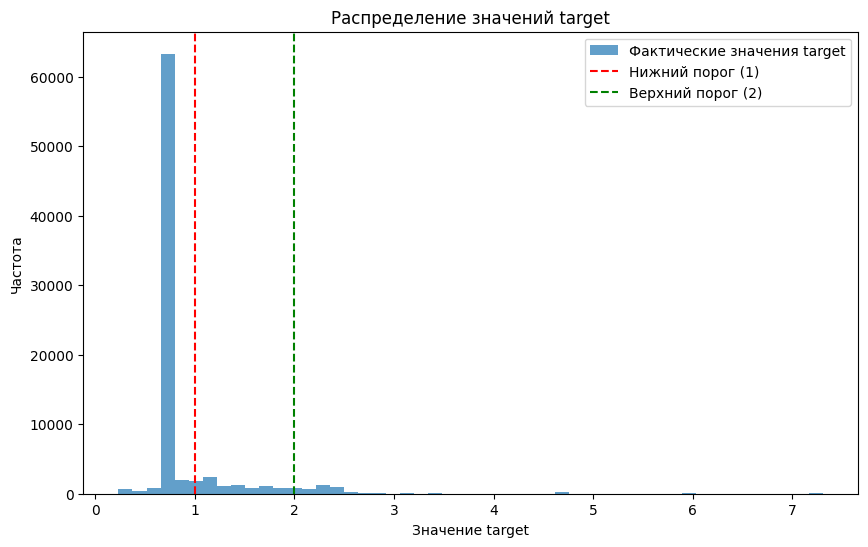

{'RMSE виртуального датчика': 0.0395448600575142,
 'MAE виртуального датчика': 0.0074882157405898216,
 'R^2 виртуального датчика': 0.9935512446076835,
 'RMSE прогноза': 0.053149257735238396,
 'MAE прогноза': 0.008500586472196703,
 'R^2 прогноза': 0.9882159861926785,
 'Среднее предсказание target при изменении gas_consumption1': 0.9164183404456077,
 'RMSE:': 0.05365284671635529,
 'MAE:': 0.008577002129508182,
 'R^2:': 0.9879916213194326}

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(target, bins=50, alpha=0.7, label='Фактические значения target')
plt.axvline(x=1, color='red', linestyle='--', label='Нижний порог (1)')
plt.axvline(x=2, color='green', linestyle='--', label='Верхний порог (2)')
plt.title('Распределение значений target')
plt.xlabel('Значение target')
plt.ylabel('Частота')
plt.legend()
plt.show()

results = {
    "RMSE виртуального датчика": rmse_VS,
    "MAE виртуального датчика": mae_VS,
    "R^2 виртуального датчика": r2_VS,
    "RMSE прогноза": rmse_forecast,
    "MAE прогноза": mae_forecast,
    "R^2 прогноза": r2_forecast,
    "Среднее предсказание target при изменении gas_consumption1": np.mean(y_pred_modified),
    "RMSE:": rmse_gas_consumption1_changed,
    "MAE:": mae_gas_consumption1_changed,
    "R^2:": r2_gas_consumption1_changed,
}

results